# Chapter 13 - Loading and Preprocessing Data With TensorFlow

In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Data API

The data API makes it possible for reading data with tensorflow and preprocess it. you just create a dataset object, and tell it where to get the data and how to transform it. TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, and prefetching.

The whole Data API revolves around the concept of a dataset: as you might suspect, this represents a sequence of data items. Usually you will use datasets that gradually read data from disk, but for simplicity let’s create a dataset entirely in RAM using `tf.data.Dataset.from_tensor_slices()`:

In [21]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [22]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a new dataset.

In [23]:
dataset = dataset.repeat(3).batch(7)

for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


Keep in mind that the dataset methods do not modify the dataset, they create new ones.

In [24]:
# the map method transform item/batch by item/batch
dataset = dataset.map(lambda x: x ** 2)

for item in dataset:
    print(item)

tf.Tensor([ 0  1  4  9 16 25 36], shape=(7,), dtype=int32)
tf.Tensor([49 64 81  0  1  4  9], shape=(7,), dtype=int32)
tf.Tensor([16 25 36 49 64 81  0], shape=(7,), dtype=int32)
tf.Tensor([ 1  4  9 16 25 36 49], shape=(7,), dtype=int32)
tf.Tensor([64 81], shape=(2,), dtype=int32)


In [25]:
# the apply method transforms the whole dataset
dataset = dataset.apply(tf.data.experimental.unbatch())

In [26]:
# filter dataset instances
dataset = dataset.filter(lambda x: x < 10)

In [27]:
# the take method let us look at a portion of the dataset
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### Shuffling the Data

In [28]:
dataset = tf.data.Dataset.range(10).repeat(3) # 0 to 9, three times
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


Considerations about this method of shuffling must be raised. One might set a batch size to a low value such that everytime a batch is sampled, the dataset may not appear to be sampled iid. One approach is to split the dataset into multiple files and read them simultaneously in **interleaved order**. To know more about this approach, go to the notebook in the book's repository.

### Preprocessing the Data

Preprocessing the data go as usual, but in the context of tensorflow, we must consider the rules to make TF functions, discussed in the last chapter.

## The TFRecord Format

The TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently. You can easily create a TFRecord file using the `tf.io.TFRecordWriter` class:

In [31]:
with tf.io.TFRecordWriter("./datasets/tfrecord_format_sample/my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [33]:
# read the data
filepaths = ["./datasets/tfrecord_format_sample/my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


By default, a `TFRecordDataset` will read files one by one, but you can make it read multiple files in parallel and interleave their records by setting `num_parallel_reads`.

### Compressed TFRecord Files

It can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection. You can create a compressed TFRecord file by setting the `options` argument:

In [34]:
# options = tf.io.TFRecordOptions(compression_type="GZIP")
# with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
#     [...]

When reading a compressed TFRecord file, you need to specify the compression type:

In [35]:
# dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")

## Preprocessing the Input Features

There are several alternative ways to preprocess the data for a neural network. In this chapter, we are going to use the approach of using a preprocessing layer directly in the model.

For example, here is how you can implement a standardization layer using a `Lambda` layer. For each feature, it subtracts the mean and divides by its standard deviation (plus a tiny smoothing term to avoid division by zero):

In [36]:
# means = np.mean(X_train, axis=0, keepdims=True)
# stds = np.std(X_train, axis=0, keepdims=True)
# eps = keras.backend.epsilon()

# model = keras.models.Sequential([
# keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps)),
#     [...] # other layers
# ])

And instead of having to declare global variables, we can declare a Standardization class:

In [37]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

Before you can use this standardization layer, you will need to adapt it to your dataset by calling the `adapt()` method and passing it a data sample. This will allow it to use the appropriate mean and standard deviation for each feature:

In [38]:
# std_layer = Standardization()
# std_layer.adapt(data_sample)

In [39]:
# model = keras.Sequential()
# model.add(std_layer)
# [...] # create the rest of the model
# model.compile([...])
# model.fit([...])

### Encoding Categorial Features Using One-Hot Vectors

Consider the `ocean_proximity` feature in the California housing dataset.

In [40]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

- We first define the vocabulary: this is the list of all possible categories.
- Then we create a tensor with the corresponding indices (0 to 4).
- Next, we create an initializer for the lookup table, passing it the list of categories and their corresponding indices.
- In the last two lines we create the lookup table, giving it the initializer and specifying the number of out-of-vocabulary (oov) buckets. If we look up a category that does not exist in the vocabulary, the lookup table will compute a hash of this category and use it to assign the unknown category to one of the oov buckets. Their indices start after the known categories, so in this example the indices of the two oov buckets are 5 and 6.

In [43]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [44]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

### Encoding Categorical Features Using Embeddings

**An embedding is a trainable dense vector that represents a category**. By default, embeddings are initialized randomly, so for example the "NEAR BAY" category could be represented initially by a random vector such as [0.131, 0.890], while the "NEAR OCEAN" category might be represented by another random vector such as [0.631, 0.791]. In this example, we use 2D embeddings, but the number of dimensions is a hyperparameter you can tweak. Since these embeddings are trainable, they will gradually improve during training; and as they represent fairly similar categories, Gradient Descent will certainly end up pushing them closer together, while it will tend to move them away from the "INLAND" category’s embedding (see Figure 13-4). Indeed, the better the representation, the easier it will be for the neural network to make accurate predictions, so training tends to make embeddings useful representations of the categories.

Let’s look at how we could implement embeddings manually, to understand how they work (then we will use a simple Keras layer instead). First, we need to create an embedding matrix containing each category’s embedding, initialized randomly; it will have one row per category and per oov bucket, and one column per embedding dimension:

In [45]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In [48]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.13770425, 0.61187863],
       [0.99558365, 0.87079966],
       [0.39352548, 0.27532458],
       [0.59721243, 0.78619385],
       [0.05042589, 0.20825803],
       [0.34178567, 0.19068134],
       [0.46905756, 0.38303804]], dtype=float32)>

We are using embeddings of 2 dimensions, but as a rule of thumb, use between 10 and 300 dimensions.

In [49]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [50]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.59721243, 0.78619385],
       [0.34178567, 0.19068134],
       [0.99558365, 0.87079966],
       [0.99558365, 0.87079966]], dtype=float32)>

The `tf.nn.embedding_lookup()` function looks up the rows in the embedding matrix, at the given indices—that’s all it does. Keras provides a `keras.layers.Embedding` layer that handles the embedding matrix (trainable, by default); when the layer is created it initializes the embedding matrix randomly, and then when it is called with some category indices it returns the rows at those indices in the embedding matrix:

In [51]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets, 
                                   output_dim=embedding_dim)

In [53]:
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.00029554, -0.03557222],
       [-0.03858506,  0.01033878],
       [-0.01497278,  0.00052623],
       [-0.01497278,  0.00052623]], dtype=float32)>

Putting everything together, we can now have a model that handles numerical and categorical features, as well as oov buckets:

In [55]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories],
                           outputs=[outputs])

This model takes two inputs: a regular input containing eight numerical features per instance, plus a categorical input (containing one categorical feature per instance). It uses a Lambda layer to look up each category’s index, then it looks up the embeddings for these indices. Next, it concatenates the embeddings and the regular inputs in order to give the encoded inputs, which are ready to be fed to a neural network.

When the `keras.layers.TextVectorization` layer is available, you can call its `adapt()` method to make it extract the vocabulary from a data sample (it will take care of creating the lookup table for you). Then you can add it to your model, and it will perform the index lookup (replacing the Lambda layer in the previous code example).

### Keras Preprocessing Layers

We can define a preprocessing layers much like a pipeline that behaves as a layers applying preprocessing step by step:

In [56]:
# normalization = keras.layers.Normalization()
# discretization = keras.layers.Discretization([...])
# pipeline = keras.layers.PreprocessingStage([normalization, discretization])
# pipeline.adapt(data_sample)

## Exercises

**1. Why would you want to use the Data API?**

The Data API is integrated with some TensorFlow features in such a way that, if used together, advanced operations such as multithreading, queueing, batching, and prefetching are handle automatically. Moreover, the Data API works seamlessly with `tf.keras`.  

**2. What are the benefits of splitting a large dataset into multiple files?**

First, we must consider what is recommended to do regarding shuffling data from small datasets. Once we have a dataset, we must shuffle it to feed it to the SGD optimization algoritm. Therefore, we effectively created a new dataset with shuffled data. Then, we create a buffer fill it up a buffer with the instances of the dataset and whenever the model asks for an instance, it will be retrieved from the buffer until the buffer is emptied and the whole process starts again until the whole dataset has been seen by the model. 

It is in our hands to choose the buffer size, and we must do so such that the buffer size is not too small, or else, shuffling will not be very effective. Considering this, arises a problem with large datasets.

Large datasets don't fit in memory and apart from that, if the dataset is too large, the buffer size will be fatally small compared to the dataset size, which destroys the effects of shuffling. The alternative we have is to shuffle the data source itself. To do that, we shuffle the data and split is in several files with reasonable sizes.

**3. During training, how can you tell that your input pipeline is the bottleneck? What can you do to fix it?**

You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches. If this is insufficient to get your GPU to 100% usage during training, make sure your preprocessing code is optimized. You can also try saving the dataset into multiple TFRecord files, and if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.

**4. Can you save any binary data to a TFRecord file, or only serialized
protocol buffers?**

TFRecord files can store arbitrary binary records but usually it is used to store file in serialized protocol buffers (protobufs) format.

**5. Why would you go through the hassle of converting all your data to the Example protobuf format? Why not use your own protobuf definition?**

Creating our own protobuf definition may be simpler. To transmit it through a network, we would need to serialize (`SerializeToString()`) and parse (`ParseFromString()`) the data. These operations are not TensorFlow operations, so they cannot be included in a TensorFlow Function. Nevertheless, TensorFlow does include special protobuf definitions for whith it provides parsing operations, one of them is the `Example` protobuf.

However, if it does not cover your use case, you can define your own protocol buffer, compile it using protoc (setting the --descriptor_set_out and --include_imports arguments to export the protobuf descriptor), and use the tf.io.decode_proto() function to parse the serialized protobufs (see the “Custom protobuf” section of the notebook for an example). It’s more complicated, and it requires deploying the descriptor along with the model, but it can be done.

**6. When using TFRecords, when would you want to activate compression? Why not do it systematically?**

Compression is only recommended when the files are in another machine and they must be downloaded for training in another machine. By applying compression to this situation, the download will run much faster because the dataset will have a smaller file size. On the other hand, if the dataset is in the same machine that will consume it, there is no need for compression because we would just waste resources having to decompress the data.

**7. Data can be preprocessed directly when writing the data files, or within the tf.data pipeline, or in preprocessing layers within your model, or using TF Transform. Can you list a few pros and cons of each option?**

If you preprocess the data when creating the data files, the
training script will run faster, since it will not have to perform
preprocessing on the fly. In some cases, the preprocessed data
will also be much smaller than the original data, so you can
save some space and speed up downloads. It may also be
helpful to materialize the preprocessed data, for example to
inspect it or archive it. However, this approach has a few cons.
First, it’s not easy to experiment with various preprocessing
logics if you need to generate a preprocessed dataset for each
variant. Second, if you want to perform data augmentation, you
have to materialize many variants of your dataset, which will
use a large amount of disk space and take a lot of time to
generate. Lastly, the trained model will expect preprocessed
data, so you will have to add preprocessing code in your
application before it calls the model.

If the data is preprocessed with the tf.data pipeline, it’s much
easier to tweak the preprocessing logic and apply data
augmentation. Also, tf.data makes it easy to build highly
efficient preprocessing pipelines (e.g., with multithreading and
prefetching). However, preprocessing the data this way will
slow down training. Moreover, each training instance will be
preprocessed once per epoch rather than just once if the data
was preprocessed when creating the data files. Lastly, the
trained model will still expect preprocessed data.

If you add preprocessing layers to your model, you will only
have to write the preprocessing code once for both training and
inference. If your model needs to be deployed to many
different platforms, you will not need to write the
preprocessing code multiple times. Plus, you will not run the
risk of using the wrong preprocessing logic for your model,
since it will be part of the model. On the downside,
preprocessing the data will slow down training, and each
training instance will be preprocessed once per epoch.
Moreover, by default the preprocessing operations will run on
the GPU for the current batch (you will not benefit from
parallel preprocessing on the CPU, and prefetching).
Fortunately, the upcoming Keras preprocessing layers should
be able to lift the preprocessing operations from the
preprocessing layers and run them as part of the tf.data
pipeline, so you will benefit from multithreaded execution on
the CPU and prefetching.

Lastly, using TF Transform for preprocessing gives you many
of the benefits from the previous options: the preprocessed data
is materialized, each instance is preprocessed just once
(speeding up training), and preprocessing layers get generated
automatically so you only need to write the preprocessing code
once. The main drawback is the fact that you need to learn how
to use this tool.

**8. Name a few common techniques you can use to encode categorical features. What about text?**

Ordinal encoding, one-hot encodding. TF-IDF, bag of words, word embeddings (for text).

**9. Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Then use `tf.data` to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the
input pipeline as efficient as possible, using TensorBoard to visualize profiling data.**

In [36]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

In [15]:
# load the fashion mnist dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [16]:
# split into training/validation sets
X_val, X_train = X_train_full[:5000], X_train_full[5000:]
y_val, y_train = y_train_full[:5000], y_train_full[5000:]

In [17]:
# shuffle the training set
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
# create dataset
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [23]:
# function to convert images and labels into Examples
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

In [25]:
# for image, label in valid_set.take(1):
#     print(create_example(image, label))

The following function saves a given dataset to a set of TFRecord files. **The examples are written to the files in a round-robin fashion**. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use the standard `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [26]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [27]:
# save the dataset in tfrecords format
train_filepaths = write_tfrecords("datasets/ch13_ex09/my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("datasets/ch13_ex09/my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("datasets/ch13_ex09/my_fashion_mnist.test", test_set)

Using `tf.data` to create an efficient dataset for each set.

In [31]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

In [32]:
def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [33]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

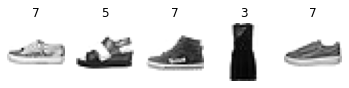

In [37]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

Adding a standardization preprocessing layer.

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
    
    
standardization = Standardization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [39]:
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 231.8194 - accuracy: 0.8407 - val_loss: 1731.3500 - val_accuracy: 0.8702
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 513.7507 - accuracy: 0.8788 - val_loss: 987.4476 - val_accuracy: 0.8812
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 412.7268 - accuracy: 0.8910 - val_loss: 53.1468 - val_accuracy: 0.8824
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 232.7943 - accuracy: 0.8990 - val_loss: 117.3360 - val_accuracy: 0.8778
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 137.5280 - accuracy: 0.9082 - val_loss: 64.0788 - val_accuracy: 0.8832


**10. In this exercise you will download a dataset, split it, create a `tf.data.Dataset` to load it and preprocess it efficiently, then build and train a binary classification model containing an Embedding layer:**

**a. Download the Large Movie Review Dataset, which contains 50,000 movies reviews from the Internet Movie Database. The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise.**

In [10]:
import numpy as np
import tensorflow as tf
from pathlib import Path
path = Path("./datasets/aclImdb_v1/aclImdb")

def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

2022-02-16 15:59:46.741648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 15:59:46.741672: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(12500, 12500, 12500, 12500)

**b. Split the test set into a validation set (15,000) and a test set (10,000).**

In [11]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

**c. Use tf.data to create an efficient dataset for each set.**

In [12]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices((tf.constant(reviews), tf.constant(labels)))

In [13]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

2022-02-16 15:59:49.259289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-16 15:59:49.259314: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 15:59:49.259329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BRSPOBITANL1634): /proc/driver/nvidia/version does not exist
2022-02-16 15:59:49.259576: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [102]:
# for X, y in imdb_dataset(train_pos, train_neg).take(3):
#     print(X)
#     print(y)
#     print()

**d. Create a binary classification model, using a `TextVectorization` layer to preprocess each review. If the
`TextVectorization` layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the `tf.strings` package, for example `lower()` to make everything lowercase, `regex_replace()` to replace punctuation with spaces, and `split()` to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the `adapt()` method.**

Let's first write a function to preprocess the reviews, cropping them to 300 characters, converting them to lower case, then replacing `<br />` and all non-letter characters to spaces, splitting the reviews into words, and finally padding or cropping each review so it ends up with exactly `n_words` tokens:

In [103]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

Now let's write a second utility function that will take a data sample with the same format as the output of the `preprocess()` function, and will output the list of the top max_size most frequent words, ensuring that the padding token is first:

In [104]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

Now we are ready to create the `TextVectorization` layer. Its constructor just saves the hyperparameters (`max_vocabulary_size` and `n_oov_buckets`). The `adapt()` method computes the vocabulary using the `get_vocabulary()` function, then it builds a `StaticVocabularyTable` (see Chapter 16 for more details). The `call()` method preprocesses the reviews to get a padded list of words for each review, then it uses the `StaticVocabularyTable` to lookup the index of each word in the vocabulary:

In [105]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [106]:
text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

Looks good! As you can see, each review was cleaned up and tokenized, then each word was encoded as its index in the vocabulary (all the 0s correspond to the `<pad>` tokens).

Now let's create another `TextVectorization` layer and let's adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling `train_set.take(500)`):

In [107]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])

text_vectorization.adapt(sample_reviews)

In [108]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 256,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 532, 335,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

Now to build our model we will need to encode all these word IDs somehow. One approach is to create bags of words: for each review, and for each word in the vocabulary, we count the number of occurences of that word in the review. For example:

In [109]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

The first review has 2 times the word 0, 2 times the word 1, 0 times the word 2, and 1 time the word 3, so its bag-of-words representation is [2, 2, 0, 1]. Similarly, the second review has 3 times the word 0, 0 times the word 1, and so on. Let's wrap this logic in a small custom layer, and let's test it. We'll drop the counts for the word 0, since this corresponds to the `<pad>` token, which we don't care about.

In [110]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [111]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

In [112]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1 # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

In [113]:
model = keras.models.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5419 - accuracy: 0.7207 - val_loss: 0.5148 - val_accuracy: 0.7383
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: 0.4690 - accuracy: 0.7673 - val_loss: 0.5042 - val_accuracy: 0.7417
Epoch 3/5
782/782 [==============================] - 6s 7ms/step - loss: 0.4180 - accuracy: 0.8070 - val_loss: 0.5068 - val_accuracy: 0.7443
Epoch 4/5
782/782 [==============================] - 6s 7ms/step - loss: 0.3470 - accuracy: 0.8534 - val_loss: 0.5407 - val_accuracy: 0.7363
Epoch 5/5
782/782 [==============================] - 6s 7ms/step - loss: 0.2634 - accuracy: 0.9031 - val_loss: 0.5719 - val_accuracy: 0.7322


We get about 73.5% accuracy on the validation set after just the first epoch, but after that the model makes no significant progress. We will do better in Chapter 16. For now the point is just to perform efficient preprocessing using `tf.data` and Keras preprocessing layers.

**e. Add an Embedding layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model.**

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt{N}$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$  is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\frac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt{N} = \frac{S}{\sqrt{N}}$.

In [114]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

Perfect. Now we're ready to train our final model. It's the same as before, except we replaced the `BagOfWords` layer with an `Embedding` layer followed by a Lambda layer that calls the compute_mean_embedding layer:

In [115]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True), # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

**f. Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible.**

In [116]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 3s 4ms/step - loss: 0.5547 - accuracy: 0.7092 - val_loss: 0.5092 - val_accuracy: 0.7391
Epoch 2/5
782/782 [==============================] - 3s 3ms/step - loss: 0.4941 - accuracy: 0.7558 - val_loss: 0.5062 - val_accuracy: 0.7409
Epoch 3/5
782/782 [==============================] - 3s 3ms/step - loss: 0.4818 - accuracy: 0.7605 - val_loss: 0.5009 - val_accuracy: 0.7431
Epoch 4/5
782/782 [==============================] - 3s 3ms/step - loss: 0.4736 - accuracy: 0.7651 - val_loss: 0.5056 - val_accuracy: 0.7429
Epoch 5/5
782/782 [==============================] - 3s 3ms/step - loss: 0.4654 - accuracy: 0.7679 - val_loss: 0.5061 - val_accuracy: 0.7441


The model is not better using embeddings (but we will do better in Chapter 16). The pipeline looks fast enough (we optimized it earlier).